# Recommendation system for restaurants using collaborative filtering (CF)

In [2]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erf

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

###User and Item based approaches
Original approaches to neighborhood based CF used user-user models. By this we mean that rating estimates are made from recorded ratings of like minded users. However, since most users tend to rate very few items, this is usually a losing proposition for explicit-rating based recommenders. Thus, most neighborhood based systems such as Amazon these days rely on item-item approaches. In these methods, a rating is estimated by other ratings made by the user on "similar" or "nearby" items: we have a K-Nearest-Neighbors algorithm, in effect.

##Outline of this Homework
The outline of this homework is as follows:

Create a database of item-item similarities. Use this to implement a neighborhood-based CF recommender that can answer simple questions like "give me more restaurants like this one". This part of the homework assumes that the similaties calculated make good "global recommendations".

In the second part, we go one step further and attempt to predict the rating that a user will give an item they have not seen before. This requires that we find the restaurants that this user would rate as similar (not just those which are globally similar).

In the third part, we implement a factor-based CF recommender using a Bayesian model. While quite a bit more complex, this allows us to pool information both about similar users and about similar restaurants.

We will scale up our system by creating a recommender on the lines of Q1 and Q2 that works on the entire data set. We will use the map-reduce paradigm to split the computation over multiple machines.

You will start simply, by working on a subset of the restaurant data before generalizing to the entire data set in Problem 4. The complete data set has 150,000 reviews, but we shall start with just about 7000. You will create this smaller set by taking all the users who had rated more than 60 restaurants, and all the businesses which had greater than 150 reviews from the larger data set. This is not a random set: indeed we use it as it a computationally tractable set that is a bit less sparse than the entire data set.

The data set has been extracted from the Yelp Phoenix restaurants dataset.

In [3]:
full_yelp_ds=pd.read_csv('bigdf.csv')
full_yelp_ds.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


In [4]:
full_yelp_group = full_yelp_ds.groupby('user_id')

In [5]:
for k,v in full_yelp_group:
    print 'key',k,'--->','value',v
    val=v
    break
v.head()

key --65q1FpAL_UQtVZ2PTGew ---> value                        user_id             business_id                 date               review_id  stars  usefulvotes_review user_name                                         categories                                biz_name   latitude   longitude  business_avg  business_review_count  user_avg  user_review_count
239     --65q1FpAL_UQtVZ2PTGew  r3r_bAfa6pZKIhQB82FizQ  2009-08-06 00:00:00  1E2xMa79MzmDobQeDXMqog      3                   1     Nader                             [Restaurants, Italian]                                PastaBAR  33.455863 -112.072167      3.358491                    106  3.953704                108
429     --65q1FpAL_UQtVZ2PTGew  eIxSLxzIlfExI6vgAbn2JA  2010-04-05 00:00:00  cr-8VthsH_j8yFTak1t7NQ      5                   2     Nader   [Burgers, Hot Dogs, American (New), Restaurants]                Lobbys Beef Burgers Dogs  33.394770 -111.908894      4.283237                    173  3.953704                108
3497    --6

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
239,--65q1FpAL_UQtVZ2PTGew,r3r_bAfa6pZKIhQB82FizQ,2009-08-06 00:00:00,1E2xMa79MzmDobQeDXMqog,3,1,Nader,"[Restaurants, Italian]",PastaBAR,33.455863,-112.072167,3.358491,106,3.953704,108
429,--65q1FpAL_UQtVZ2PTGew,eIxSLxzIlfExI6vgAbn2JA,2010-04-05 00:00:00,cr-8VthsH_j8yFTak1t7NQ,5,2,Nader,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.394770,-111.908894,4.283237,173,3.953704,108
3497,--65q1FpAL_UQtVZ2PTGew,yGmdo1ENajB98iryHGoWFw,2010-10-07 00:00:00,f8iB_xmmMBjVbLPQL1v7kA,4,1,Nader,"[Bars, Dive Bars, Burgers, Nightlife, Sports B...",Monkey Pants Bar & Grill,33.394126,-111.939464,3.571429,70,3.953704,108
5162,--65q1FpAL_UQtVZ2PTGew,-sC66z4SO3tR7nFCjfQwuQ,2010-04-04 00:00:00,Xhzo4VoHtjyTMJ8tt6TxMw,4,0,Nader,"[Mexican, Restaurants]",Gallo Blanco Cafe,33.491120,-112.079081,4.145957,507,3.953704,108
7600,--65q1FpAL_UQtVZ2PTGew,bzDs0u8I-z231QVdIQWkrA,2010-07-22 00:00:00,lk6_3yIyphQafvZrtMC5tA,4,2,Nader,"[Mexican, Restaurants]",Los Reyes de la Torta,33.570813,-112.065737,4.247967,246,3.953704,108


In [6]:
full_yelp_group.review_id.count()

user_id
--65q1FpAL_UQtVZ2PTGew    108
--AqBuo717RyacADExYbSA      1
--LzFD0UDbYE-Oho3AhsOg      1
--M-cIkGnH1KhnLaCOmoPQ      1
--RD0Z_F0tV4L-AzhOzXYA      1
--VxRvXk3b8FwsSbC2Zpxw     15
--dofeOsROFpm0q_dmqTTA      1
--lMCM6K8-9NTvPlbCMXEA      1
--rlgfAvvi0BtfRDA1p-VQ      7
-01H9S7YxFrhRgNdvxmaVQ      2
-06LYbA4Qm_9E83KNT1Jrg      2
-0Js-tuVNbipC-AG_1lfbw      1
-0Ycl6yN0BsX1U70-SZOYw      2
-0gh7015nDOhZlwzlNNxwA      2
-0heMfd5ngN1qm3vrVL83g      1
...
zxIEQP7bnqGyQ9dZ18TUVQ     9
zxcrlC3cmH5S2TGIxuLwBw     1
zxrPBLIMPMv0fx9dAYpiRw     1
zxxgw3vZyzISNGqTuvxJjw     1
zyMcgGk6bSUdHbl4StOIeA     2
zyYXmyCYBn-yBb_4xJ_maw     3
zyatWxIJFWqHj64kTzPc-g     1
zzEvmdVGXvcVGpgWNRlXtg     1
zzL0NsoMVMub2jmUTsFD4A     1
zzQ2b-9Xu7-Tl8PNGZuspg     2
zzVpQ6IBxeW3ZDdg0Ep_wg     5
zzWUzYAj8SXwohidVLax9Q     1
zzhdnNeg65wupOXqYtGyJw     1
zzmRKNph-pBHDL2qwGv9Fw    16
zztT9KKp0rmJRMeMl4CqzQ     4
Name: review_id, Length: 34789, dtype: int64

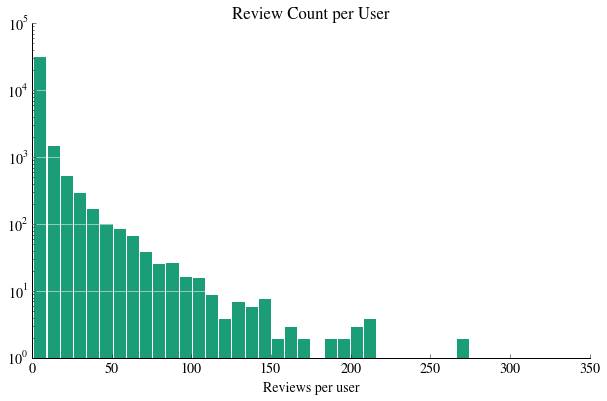

In [7]:
plt.hist(full_yelp_group.review_id.count(), bins=40, log=True)
remove_border()
plt.xlabel("Reviews per user")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per User");

In [8]:
full_yelp_group_bid = full_yelp_ds.groupby('business_id')    

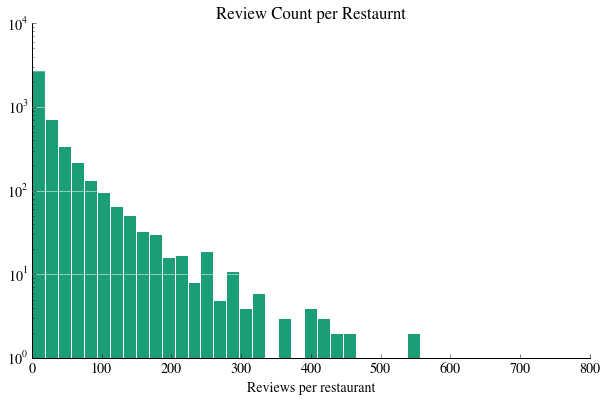

In [9]:
plt.hist(full_yelp_group_bid.review_id.count(), bins=40, log=True)
remove_border()
plt.xlabel("Reviews per restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per Restaurnt");

In [10]:
print "Total Number of entries",full_yelp_ds.shape[0]
print "Number of users",full_yelp_ds.user_id.unique().shape[0]
print "Number of Bussiness", full_yelp_ds.business_id.unique().shape[0]

Total Number of entries 149319
Number of users 34789
Number of Bussiness 4503


In [11]:
full_yelp_ds.stars.mean()

3.7414126802349332

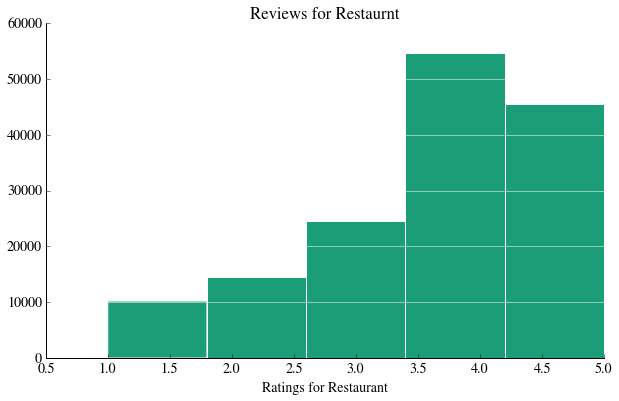

In [12]:
plt.hist(full_yelp_ds.stars, bins=5)
remove_border()
plt.xlabel("Ratings for Restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Reviews for Restaurnt");

The following function is used to re-compute review counts and averages whenever you subset a reviews data frame. We'll use it soon to construct a smaller, more computationally tractable data frame.

In [13]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu=ldf.groupby('user_id')
    ldfb=ldf.groupby('business_id')
    user_avg=ldfu.stars.mean()
    user_review_count=ldfu.review_id.count()
    business_avg=ldfb.stars.mean()
    business_review_count=ldfb.review_id.count()
    nldf=ldf.copy()
    nldf.set_index(['business_id'], inplace=True)
    nldf['business_avg']=business_avg
    nldf['business_review_count']=business_review_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user_id'], inplace=True)
    nldf['user_avg']=user_avg
    nldf['user_review_count']=user_review_count
    nldf.reset_index(inplace=True)
    return nldf

1.3 Create a smaller data set in dataframe smalldf by looking for those businesses with more than 150 reviews and those users with more than 60 reviews. Include all the columns that were there in the parent dataframe. Since you have created a subset of the data set, use the method provided above to recalculate the averages. Print the number of unique users and items in this data set.

Note that while this cut makes sure we have prolific users, the cut on businesses restores sparsity by reducing the number of reviews per user.

In [14]:
full_yelp_ds.head(2)

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,9yKzy9PApeiPPOUJEtnvkg,2011-01-26 00:00:00,fWKvX83p0-ka4JS3dc6E5A,5,5,Jason,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.796954,197
1,SBbftLzfYYKItOMFwOTIJg,9yKzy9PApeiPPOUJEtnvkg,2008-05-04 00:00:00,DASdFe-g0BgfN9J2tanStg,5,1,Jennifer,"[Breakfast & Brunch, Restaurants]",Morning Glory Cafe,33.390792,-112.012504,3.87156,109,3.473684,57


In [15]:
smldf = full_yelp_ds[(full_yelp_ds.business_review_count.values >  150) & (full_yelp_ds.user_review_count > 60)]
smalldf=recompute_frame(smldf)

In [16]:
print "Total Number of entries",smalldf.shape[0]
print "Number of users",smalldf.user_id.unique().shape[0]
print "Number of Bussiness", smalldf.business_id.unique().shape[0]

Total Number of entries 6165
Number of users 240
Number of Bussiness 172


How does this compare to the parent data set, in terms of size and sparsity? Once again, plot histograms of the review count grouped by user, and by the review count grouped by business, respectively, and describe the results

In [17]:
smalldf_grp_user = smalldf.groupby('user_id')

In [18]:
smalldf_grp_bus = smalldf.groupby('business_id')

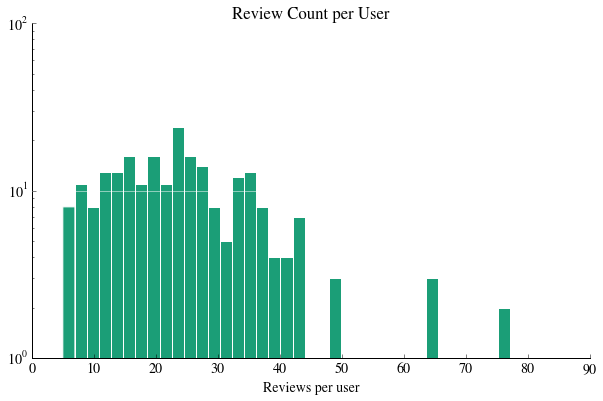

In [19]:
plt.hist(smalldf_grp_user.review_id.count(), bins=40, log=True)
remove_border()
plt.xlabel("Reviews per user")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per User");

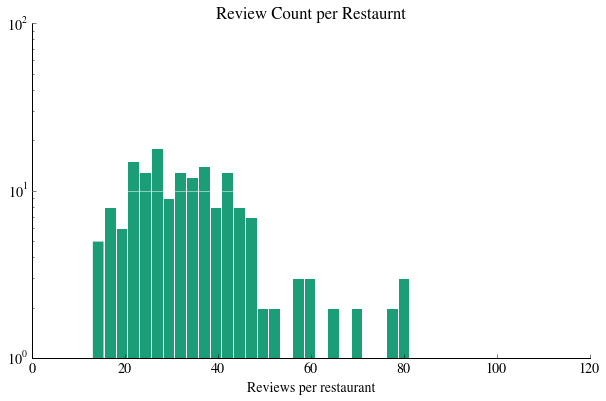

In [20]:
plt.hist(smalldf_grp_bus.review_id.count(), bins=40, log=True)
remove_border()
plt.xlabel("Reviews per restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per Restaurnt");

1.4 Compute histograms of the average user rating in the smaller data set, and the average business rating in the smaller data set. Print the overall mean.

In [21]:
smalldf.head()

,user_id,business_id,date,review_id,stars,usefulvotes_review,user_name,categories,biz_name,latitude,longitude,business_avg,business_review_count,user_avg,user_review_count
0,rLtl8ZkDX5vH5nAx9C3q5Q,eIxSLxzIlfExI6vgAbn2JA,2011-05-12 00:00:00,z4G1g3VcdfigCUtVDFRL1w,4,5,Jason,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.709677,62
1,C6IOtaaYdLIT5fWd7ZYIuA,eIxSLxzIlfExI6vgAbn2JA,2011-04-12 00:00:00,480M-xDpRaA1gCVCqIG4WA,4,14,Daren,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,4.000000,15
2,mlBC3pN9GXlUUfQi1qBBZA,eIxSLxzIlfExI6vgAbn2JA,2011-09-17 00:00:00,q_T6FtScTul_yYIGyrgTxA,3,0,Jennifer,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.750000,12
3,T7J9ae0wTskrI_Bgwp-4cA,eIxSLxzIlfExI6vgAbn2JA,2011-03-09 00:00:00,YPKedK7JuKC36cDAKuDGTQ,3,2,Jasmine,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.696970,33
4,nbofxFWHORebBHh10OgYLA,eIxSLxzIlfExI6vgAbn2JA,2011-07-28 00:00:00,y7yBnfbPxZJ_L93tnxMP3g,2,1,Christopher,"[Burgers, Hot Dogs, American (New), Restaurants]",Lobbys Beef Burgers Dogs,33.39477,-111.908894,4.04,25,3.833333,12


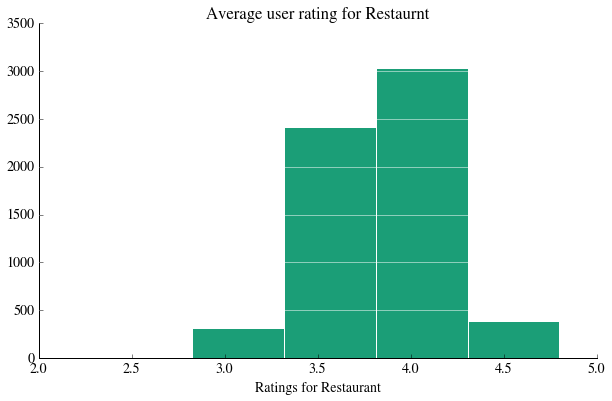

In [22]:
plt.hist(smalldf.user_avg.values, bins=5)
remove_border()
plt.xlabel("Ratings for Restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Average user rating for Restaurnt");

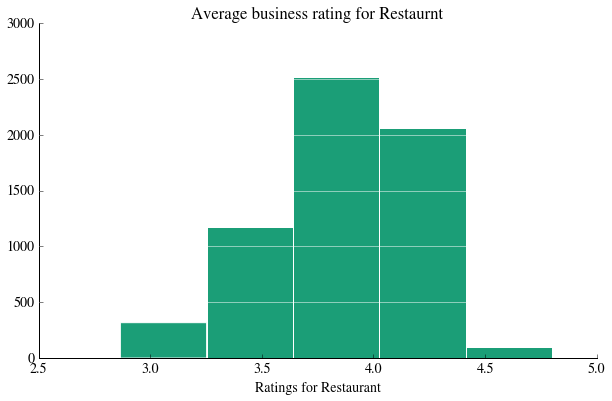

In [23]:
plt.hist(smalldf.business_avg.values, bins=5)
remove_border()
plt.xlabel("Ratings for Restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Average business rating for Restaurnt");

In [24]:
print "Overall mean", smalldf.stars.mean()

Overall mean 3.86763990268


##Common Support
Lets now make a histogram of the common user support (the number of common reviewers) of each pair of restaurants on the smaller set, and print the mean. Pay attention to the code, as you will use parts of it later. (This code takes a bit of time to run, so be patient).

The common support is an important concept, as for each pair of restaurants, its the number of people who reviewed both. It will be used to modify similarity between restaurants. If the common support is low, the similarity is less believable.

Mean support is: 6.84679722562


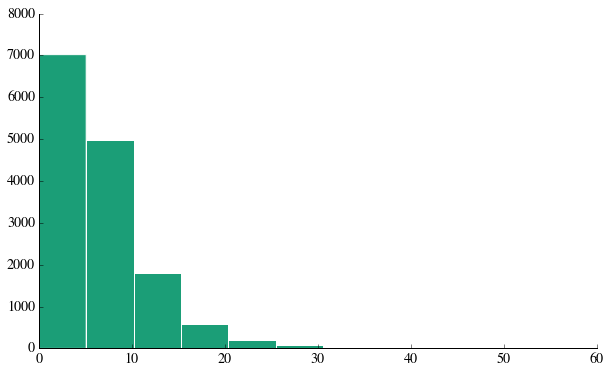

In [25]:
restaurants=smalldf.business_id.unique()
supports=[]
for i,rest1 in enumerate(restaurants):
    for j,rest2 in enumerate(restaurants):
        if  i < j:
            rest1_reviewers = smalldf[smalldf.business_id==rest1].user_id.unique()
            rest2_reviewers = smalldf[smalldf.business_id==rest2].user_id.unique()
            common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
            supports.append(len(common_reviewers))
print "Mean support is:",np.mean(supports)
plt.hist(supports)
remove_border()

In [26]:
u=smalldf[smalldf.business_id=='eIxSLxzIlfExI6vgAbn2JA'].user_id.unique()
type(u)

numpy.ndarray

##Calculating Simliarity

Users rate restaurants on a scale of 1-5. Even though this rating is integer valued, for the purposes of this assignment we shall treat it as a real number.

Even though each reviewer uses the same 5-star scale when rating restaurants, comparing two users by comparing their raw user ratings can be problematic. Consider a user whose average rating is 2. This is a curmudgeonly user. Consider another whose average rating is 4. This is a rather enthusiastic one. How should we compare a 3 rating by the curmudgeonly one to a 5 rating of the enthusiastic one?

It is for this purpose that we must subtract the average rating of the user from the actual rating of the restaurants in computing the similarity of two restaurants. This makes the above ratings by the two users comparable. We do this in the function pearson_sim defined below.

If there is no common support (n_common=0), we have no basis for making a similarity estimate, and so we set the similarity to 0. In the case that the individual restaurant rating variance is 0, such as in the case where there is only one common reviewer (n_common=1), we return the NaN that the scipy pearsonr returns. We will deal with it soon,

In [27]:
from scipy.stats.stats import pearsonr
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    """
    Given a subframe of restaurant 1 reviews and a subframe of restaurant 2 reviews,
    where the reviewers are those who have reviewed both restaurants, return 
    the pearson correlation coefficient between the user average subtracted ratings.
    The case for zero common reviewers is handled separately. Its
    ok to return a NaN if any of the individual variances are 0.
    """
    if n_common==0:
        rho=0.
    else:
        diff1=rest1_reviews['stars']-rest1_reviews['user_avg']
        diff2=rest2_reviews['stars']-rest2_reviews['user_avg']
        rho=pearsonr(diff1, diff2)[0]
    return rho

The function get_restaurant_reviews defined below takes a restaurant business_id and a set of users, and returns the reviews of that restaurant by those users. You will use this function in calculating a similarity function, in 1.5.

In [28]:
def get_restaurant_reviews(restaurant_id, df, set_of_users):
    """
    given a resturant id and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.user_id.isin(set_of_users)) & (df.business_id==restaurant_id)
    reviews = df[mask]
    reviews = reviews[reviews.user_id.duplicated()==False]
    return reviews

Write a function calculate_similarity that operates between two restaurants and calculates a similarity for them, taking a dataframe and a similarity function similarity_func. An example of the similarity_func is the pearson_sim we defined above. calculate_similarity operates as follows:

For each of the two restaurants, get the set of reviewers who have reviewed the restaurant and compute the intersection of these two sets. Also compute the number of common reviewers n_common.

Use the function get_restaurant_reviews defined below to get the reviews for each restaurant as made by these common reviewers. Notice that get_restaurant_reviews returns a sub data frame of reviews.

Calculate the similarity using similarity_func which takes the two reviews dataframes from part 2 and the number of common reviewers n_common as arguments

Return the similarity and n_common in a tuple (sim, n_common). If the similarity is a NaN, set the similarity to 0.



In [35]:
def calculate_similarity(rest1, rest2, df, similarity_func):
    rest1_reviewers = smalldf[smalldf.business_id==rest1].user_id.unique()
    rest2_reviewers = smalldf[smalldf.business_id==rest2].user_id.unique()
    common_reviewers = set(rest1_reviewers).intersection(rest2_reviewers)
    n_common = len(common_reviewers)
    
    review1 = get_restaurant_reviews(rest1, df, common_reviewers)
    review2 = get_restaurant_reviews(rest2, df, common_reviewers)
    
    similarity = similarity_func(review1, review2, n_common)
    
    if np.isnan(similarity):
        return 0, n_common
    return similarity, n_common

##Making a database of similarities

We now move to calculating a global database of pairwise restaurant similarities. We provide you here with a function to make a database of the similarities for each pair of restaurants in the database. The class Database is initialized in its constructor by taking as arguments a dataframe of reviews. The method populate_by calculating iterates over every possible pair of business_id's in the dataframe and populates the database with similarities and common supports. It takes as arguments a function the similarity function similarity_func like pearson_sim (calculate_similarity then uses this to calculate the similarity). The get method on the database can be used to retrieve the similarity for two business ids.

In [36]:
class Database:
    "A class representing a database of similaries and common supports"
    
    def __init__(self, df):
        "the constructor, takes a reviews dataframe like smalldf as its argument"
        database={}
        self.df=df
        self.uniquebizids={v:k for (k,v) in enumerate(df.business_id.unique())}
        keys=self.uniquebizids.keys()
        l_keys=len(keys)
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)
        
    def populate_by_calculating(self, similarity_func):
        """
        a populator for every pair of businesses in df. takes similarity_func like
        pearson_sim as argument
        """
        items=self.uniquebizids.items()
        for b1, i1 in items:
            for b2, i2 in items:
                if i1 < i2:
                    sim, nsup=calculate_similarity(b1, b2, self.df, similarity_func)
                    self.database_sim[i1][i2]=sim
                    self.database_sim[i2][i1]=sim
                    self.database_sup[i1][i2]=nsup
                    self.database_sup[i2][i1]=nsup
                elif i1==i2:
                    nsup=self.df[self.df.business_id==b1].user_id.count()
                    self.database_sim[i1][i1]=1.
                    self.database_sup[i1][i1]=nsup
                    

    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.uniquebizids[b1]][self.uniquebizids[b2]]
        nsup=self.database_sup[self.uniquebizids[b1]][self.uniquebizids[b2]]
        return (sim, nsup)

In [37]:
db=Database(smalldf)
db.populate_by_calculating(pearson_sim)

In [38]:
# Checking the similarity and number of common reviewrs b/w pair of restaurants.
db.get("z3yFuLVrmH-3RJruPEMYKw", "zruUQvFySeXyEd7_rQixBg")

(0.39904554525734559, 7)

##K-Nearest restaurants (in similarity)

We are now going to find the k-nearest restaurants to a given restaurant based on the database of similarities that we calculated. But we have a problem.

Consider the two cases where there is just one common reviewer, and where there are 40. In the former case, we might get a artificially high similarity based on the tastes of just this user, and thus we must reduce its importance in the nearest-neighbor calculation. In the latter case, we would get a much more unbiased estimator of the similarity of the two restaurants.

To control the effect of small common supports, we can shrink our pearson co-efficients. We shall do this by using the "regularization" parameter reg:

Recall the notions of regularization introduced in class. We want to reduce the variance in our estimates, so we pull our estimates in toward a conservative point in a way that strongly corrals in estimates when there is very little data, but allows the data to speak when there is a lot. This can be shown as equivalent to adding in a reg amount of bayesian prior, as Joe has alluded to in class.

A good value of the regularizer is intuitively one that doesn't affect the similarity when the common support is high ~10, but has a large effect when the support is small. In this case, values of 2-4 are good. Usually, the value of reg is determined using cross-validation, but for the sake of simplicity we will generally set it to 3.

In [39]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

Now we can move to writing a knearest function, which finds the k nearest neighbors of a given restaurant based on the shrunk similarities we calculate. Note that as defined here, the nearest neighbors are global over the entire set of restaurants, as opposed to being restricted to the restaurants a user has reviewed(we shall do that in the next problem). Thus, this is an expensive function!

Write a knearest that returns a k-length sorted list of 3-tuples each corresponding to a restaurant. The tuple structure is (business_id, shrunken similarity score, common support) where the similarity score and common support are with respect to the restaurant whose neighbors we are finding, and the business_id is the id of the "nearby" restaurant found. The nearby restaurants are found from a supplied numpy array of restaurants set_of_restaurants. The spec for the function is given below. HINT: use itemgetter from the operator module to do the sorting.

In [65]:
# knearest

# Parameters
# ----------
# restaurant_id : string
#     The id of the restaurant whose nearest neighbors we want
# set_of_restaurants : array
#     The set of restaurants from which we want to find the nearest neighbors
# dbase : instance of Database class.
#     A database of similarities, on which the get method can be used to get the similarity
#   of two businessed. e.g. dbase.get(rid1,rid2)
# k : int
#     the number of nearest neighbors desired, default 7
# reg: float
#     the regularization.
    
  
# Returns
# --------
# A sorted list
#     of the top k similar restaurants. The list is a list of tuples
#     (business_id, shrunken similarity, common support).
from operator import itemgetter
def knearest(rest_id, set_of_restaurants, db, k, reg=3):
    simi=[]
    for r in set_of_restaurants:
        if r != rest_id:
            si,cs = db.get(rest_id, r)
            sim = shrunk_sim(si,cs, reg=reg)
            simi.append((r,sim,cs))
    simi=sorted(simi, key=itemgetter(1), reverse=True)       
    return simi[0:k]

Ok it's time to recommend!
Lets choose the two very different businesses in the dataframe

In [66]:
testbizid="eIxSLxzIlfExI6vgAbn2JA"
testbizid2="L-uPZxooP_ziXCtRrWi8Pw"

In [67]:
# We provide functions to look up a business name given a business id, and a username given a user id.
def biznamefromid(df, theid):
    return df['biz_name'][df['business_id']==theid].values[0]
def usernamefromid(df, theid):
    return df['user_name'][df['user_id']==theid].values[0]

In [68]:
print testbizid, biznamefromid(smalldf,testbizid)
print testbizid2, biznamefromid(smalldf, testbizid2)

eIxSLxzIlfExI6vgAbn2JA Lobbys Beef Burgers Dogs
L-uPZxooP_ziXCtRrWi8Pw Café Monarch


##Get top matches
Its now time to answer the question: "if you liked this, you might also like these". We use our testbizid and testbizid2 to compute the k=7 nearest neighbors with a regularization of 3. . We print these top 7 matches names, along with their similarity coefficient and common support.

In [69]:
tops=knearest(testbizid, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For ",biznamefromid(smalldf, testbizid), ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

For  Lobbys Beef Burgers Dogs , top matches are:
0 La Condesa Gourmet Taco Shop | Sim 0.598714448434 | Support 6
1 Citizen Public House | Sim 0.571428571429 | Support 4
2 FnB | Sim 0.527129890943 | Support 5
3 Defalco's Italian Grocery | Sim 0.519456555658 | Support 6
4 Republic Ramen + Noodles | Sim 0.519140146937 | Support 5
5 unPhogettable | Sim 0.5 | Support 3
6 Haus Murphy's | Sim 0.467637235308 | Support 3


In [70]:
tops2=knearest(testbizid2, smalldf.business_id.unique(), db, k=7, reg=3.)
print "For ",biznamefromid(smalldf, testbizid2), ", top matches are:"
for i, (biz_id, sim, nc) in enumerate(tops2):
    print i,biznamefromid(smalldf,biz_id), "| Sim", sim, "| Support",nc

For  Café Monarch , top matches are:
0 Postino Arcadia | Sim 0.625 | Support 5
1 The Main Ingredient Ale House And Café | Sim 0.571428571429 | Support 4
2 Brio Tuscan Grille | Sim 0.571428571429 | Support 4
3 Kazimierz World Wine Bar | Sim 0.5 | Support 3
4 Harlow's Cafe | Sim 0.5 | Support 3
5 The Fry Bread House | Sim 0.5 | Support 3
6 Cien Agaves Tacos & Tequila | Sim 0.5 | Support 3


Lets now turn our attention to another question: what are the top recommendations for a user? To answer this we must find the user's top rated restaurants, find the nearest neighbors of these restaurants, merge these lists while removing the duplicates and the ones that the user has already rated, and sort by the restaurant's average rating. We provide the code to get the user's top choices in a subset data frame.

In [71]:
def get_user_top_choices(user_id, df, numchoices=5):
    "get the sorted top 5 restaurants for a user by the star rating the user gave them"
    udf=df[df.user_id==user_id][['business_id','stars']].sort(['stars'], ascending=False).head(numchoices)
    return udf
testuserid="7cR92zkDv4W3kqzii6axvg"
print "For user", usernamefromid(smalldf,testuserid), "top choices are:" 
bizs=get_user_top_choices(testuserid, smalldf)['business_id'].values
[biznamefromid(smalldf, biz_id) for biz_id in bizs]

For user Vern top choices are:


['Tee Pee Mexican Food',
 'Local Breeze',
 "Carly's Bistro",
 'District American Kitchen and Wine Bar',
 'Sonora Mesquite Grill']

In [72]:
uudf=get_user_top_choices("7cR92zkDv4W3kqzii6axvg", smalldf, numchoices=5)
uudf

,business_id,stars
5201,soiGohHtWOltGeomkSxzEw,5
5056,GAPqG0WNBBidKeZTMpEZ-w,5
3583,zmFc8M-hS4uuyY0hklIpoQ,5
26,9ziO3NpoNTKHvIKCBFB_fQ,4
4670,KGX7O-_WqOIy9o7u9NOa9A,4


##Get top recommendations for user.
1.7 Its your job now to write a function get_top_recos_for_user which takes as arguments a userid, the n top choices for the user, the dataframe, k, and a regularizer, and returns the top recommendations obtained from combining the restaurants that are neighbors of each of the n choices, in the way described in the previous paragraph. This returned list is a list of tuples (restaurant_id, business_avg) sorted by business_avg where business_avg is the average rating of the restaurant over the dataframe.

In [122]:
# Function
# --------
# get_top_recos_for_user

# Parameters
# ----------
# userid : string
#     The id of the user for whom we want the top recommendations
# df : Dataframe
#     The dataframe of restaurant reviews such as smalldf
# dbase : instance of Database class.
#     A database of similarities, on which the get method can be used to get the similarity
#   of two businesses. e.g. dbase.get(rid1,rid2)
# n: int
#     the n top choices of the user by star rating
# k : int
#     the number of nearest neighbors desired, default 8
# reg: float
#     the regularization.
    
  
# Returns
# --------
# A sorted list
#     of the top recommendations. The list is a list of tuples
#     (business_id, business_avg). You are combining the k-nearest recommendations 
#     for each of the user's n top choices, removing duplicates and the ones the user
#     has already rated.

def get_top_recos_for_user(userid, df, dbase, n=5, k=7, reg=3.):
    bizs=get_user_top_choices(userid, df, numchoices=n)['business_id'].values
    rated_by_user=df[df.user_id==userid].business_id.values
    tops=[]
    for ele in bizs:
        t=knearest(ele, df.business_id.unique(), dbase, k=k, reg=reg)
        for e in t:
            if e[0] not in rated_by_user:
                tops.append(e)

    #there might be repeats. unique it
    ids=[e[0] for e in tops]
    uids={k:0 for k in list(set(ids))}

    topsu=[]
    for e in tops:
        if uids[e[0]] == 0:
            topsu.append(e)
            uids[e[0]] =1
    topsr=[]     
    for r, s,nc in topsu:
        avg_rate=df[df.business_id==r].stars.mean()
        topsr.append((r,avg_rate))
        
    topsr=sorted(topsr, key=itemgetter(1), reverse=True)

    if n < len(topsr):
        return topsr[0:n]
    else:
        return topsr

In [123]:
print "For user", usernamefromid(smalldf,testuserid), "the top recommendations are:"
toprecos=get_top_recos_for_user(testuserid, smalldf, db, n=5, k=7, reg=3.)
for biz_id, biz_avg in toprecos:
    print biznamefromid(smalldf,biz_id), "| Average Rating |", biz_avg

For user Vern the top recommendations are:
Rokerij | Average Rating | 4.37931034483
Wildfish Seafood Grille | Average Rating | 4.29411764706
Defalco's Italian Grocery | Average Rating | 4.23255813953
Cornish Pasty Company | Average Rating | 4.20689655172
Pappadeaux Seafood Kitchen | Average Rating | 4.18518518519
